In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from agent import Agent, Env
from pfilter import ParticleFilter
from scipy.special import logsumexp

In [2]:
np.clip([0,1,2],0,2)

array([0, 1, 2])

In [3]:
np.random.seed(1235)
random.seed(1235)

In [4]:
im_x = 30
im_y = 30

seqlen = 800

n_agents = 6

In [5]:
env = Env(*[Agent(im_x, im_y) for _ in range(n_agents)])

In [6]:
# env.agents[0].dim = env.agents[1].dim
# env.agents[0].pos = env.agents[1].pos
# env.agents[0].vel = env.agents[1].vel

In [7]:
aa = env.step()

In [8]:
aa

[]

In [9]:
def all_permutations(l):
    if l == 0:
        return [[0]]
    else:
        prev = all_permutations(l-1)
        ans = []
        for i in range(l+1):
            for perm in prev:
                tmp = perm[:]
                tmp.insert(i, l)
                ans.append(tmp)
        return ans

In [10]:
def evol_model(particles):
    particles = particles.copy()
    
    xy, wh = particles[:,:2], particles[:,2:4]
    vel = particles[:,4:]
    
    vel += np.random.normal(size=vel.shape)/12
    vel = np.clip(vel, -2, 2)
    
    xy += vel
    
    f = np.logical_or( xy[:,0] < 0, xy[:,0] >= im_x-1)
    vel[f,0] *= -1

    f = np.logical_or( xy[:,1] < 0, xy[:,1] >= im_y-1)
    vel[f,1] *= -1
    
    wh += np.random.normal(size=wh.shape)/20
    wh = np.clip(wh, 1, 30)
    
    xy = np.clip(xy, 0.1, np.array([im_x - 1.1, im_y - 1.1], dtype='float64'))
    
    new_particles = np.concatenate([xy, wh, vel], axis=-1)
    return new_particles

def observe_model(particles, observe, beta=None):
    xy, wh = particles[:,:2], particles[:,2:4]
    
    xyxy = np.concatenate([xy, xy + wh], axis=-1)
    
    whs = np.concatenate([wh,wh], axis=-1)
    #whs = np.array([10.]*4)
    
    ds = []
    for obs in observe:
        logd = - np.sqrt(2)*np.abs(xyxy - obs)/(whs/12) - np.log(np.sqrt(2)*whs/12)
        #logd = - (xyxy - obs)**2/(2*(whs/12)**2) - np.log(np.sqrt(2*np.pi)*whs/12)
        logd = np.clip(logd, -10000, 10000)
        logd = np.sum(logd, axis=-1)
        ds.append(logd)
    
    
    ds = np.array(ds)

    if beta is not None:
        beta = np.array(beta)
        tmp = logsumexp(ds, b=beta[:,np.newaxis], axis=0)
        #print(beta)
        #print(tmp)
        if np.max(beta) < 1e-3:
            return 0
        else:
            return tmp
    else:
        return ds

In [11]:
filters = []
aa_ = env.step(see_all=True)
for i in range(n_agents):
    filt = ParticleFilter(1000, 4 + 2, evol_model, observe_model, resample_criterion=0.1)
    aa = aa_[i]
    filt.particles[:,4:] = np.random.normal(size=filt.particles[:, 4:].shape)*3
    filt.particles[:, :2] = aa[:2] + np.random.normal(size=filt.particles[:, :2].shape)*10#*0.1
    filt.particles[:, 2:4] = np.clip(aa[2:4] - aa[:2] + np.random.normal(size=filt.particles[:, 2:4].shape)*0.1, 1, 100)
    filters.append(filt)

In [12]:
observe = []
true = []
for _ in range(seqlen):
    observe.append(env.step())
    true.append([agent.pos for agent in env.agents])
    
observe = np.array(observe)
true = np.array(true)

In [13]:
agent = env.agents[0]

In [14]:
agent.w, agent.h

(8, 6)

In [15]:
# ao = list(observe)
# ao = iter(ao)

In [16]:
filtrated = [[]]
fed = [[]]
mres = 0
counter = 0

for obs in observe:
#obs = next(ao)
    betamat = np.zeros([len(filters), len(obs)], dtype='float64')

    for j, oo in enumerate(obs):
        for i, filt in enumerate(filters):
            filt.logweights -= logsumexp(filt.logweights,b=1/len(filt.logweights))
            ds = observe_model(filt.particles, [oo])[0] + filt.logweights
            #print('logweights {} {}: {}'.format(i, j, ds))
            betamat[i, j] = np.mean(np.exp(ds))
            mres += betamat[i,j]
            counter += 1
    #betamat[np.isnan(betamat)] = 0
    #print(betamat)
    if np.any(np.isnan(betamat)):
        print('broken!')
        break

    betaij = np.zeros_like(betamat)
    for perm in all_permutations(len(filters) - 1):
        for k, j in enumerate(perm[:len(obs)]):
            betaij[j, k] += np.prod(np.diag(betamat[perm,:][:len(obs)]))

    betaij /= np.sum(betaij)
    #print(betaij)
    #betaij[np.isnan(betaij)] = 0

    for i, filt in enumerate(filters):
        part, w = filt.step(obs, betaij[i,:])
        fed[-1].append((part, w))
        ix = np.random.choice(np.arange(len(part)), size=len(part), p=w)
        filtrated[-1].append(part[ix])
        #print('after update {}'.format(filt.logweights))
    filtrated.append([])
    fed.append([])

In [17]:
print(mres/counter)

0.00224934248609


In [18]:
betamat

array([[  1.94808116e-072,   6.11108035e-011,   2.77116548e-009,
          6.46496225e-092,   6.10676289e-058,   1.68568604e-057],
       [  3.35896042e-042,   2.77982269e-028,   6.26812455e-027,
          8.80087288e-058,   1.22928507e-068,   1.47067402e-028],
       [  6.55794789e-015,   9.71877705e-068,   7.48229573e-062,
          3.59297607e-030,   1.78289963e-054,   1.94806306e-002],
       [  4.17096927e-040,   1.60122262e-049,   6.08365232e-047,
          3.56528892e-056,   5.92097500e-003,   7.33862066e-053],
       [  6.89780088e-003,   8.90250875e-081,   1.65982556e-074,
          5.39184448e-009,   4.17830248e-034,   2.57468724e-016],
       [  2.29341416e-024,   5.26923346e-114,   1.07571557e-107,
          2.44645448e-004,   1.51219712e-081,   6.85089427e-035]])

In [19]:
betaij

array([[  1.99572975e-136,   5.53515851e-002,   1.11315082e-001,
          2.85535344e-174,   2.67000770e-094,   2.60083510e-109],
       [  7.56506319e-089,   1.11315082e-001,   5.53515851e-002,
          8.54541915e-123,   1.24848439e-087,   4.98845783e-063],
       [  2.09424520e-027,   2.93806868e-067,   4.98816402e-063,
          8.61891342e-060,   1.36723640e-099,   1.66666667e-001],
       [  7.11183605e-070,   1.33156135e-088,   1.11565376e-087,
          5.69881849e-106,   1.66666667e-001,   4.21234698e-095],
       [  1.66666667e-001,   2.73230149e-092,   1.12339941e-087,
          1.22129563e-027,   7.11183605e-070,   2.09424520e-027],
       [  1.22129563e-027,   3.56421480e-130,   1.60460972e-125,
          1.66666667e-001,   5.67270872e-122,   1.22814751e-050]])

In [20]:
filtrated = np.array(filtrated[:-1])

In [21]:
filtrated.shape

(800, 6, 1000, 6)

In [22]:
filtrated = filtrated.transpose([0,2,1,3])

In [23]:
fmean = filtrated.mean(axis=1)

In [24]:
fmean.shape

(800, 6, 6)

In [25]:
filtrated.shape

(800, 1000, 6, 6)

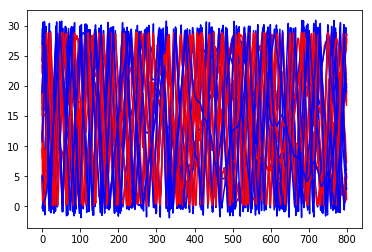

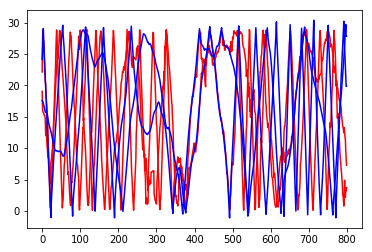

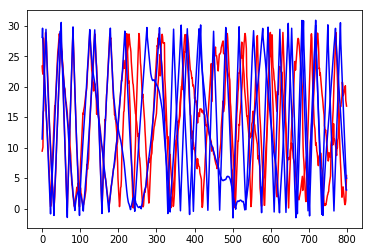

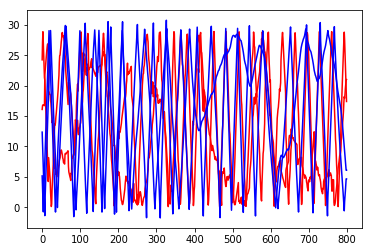

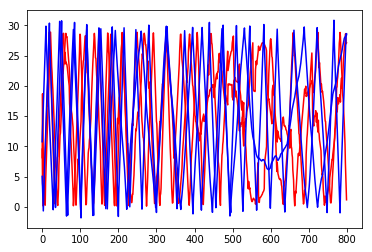

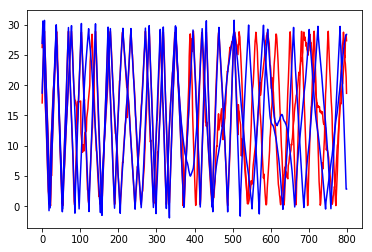

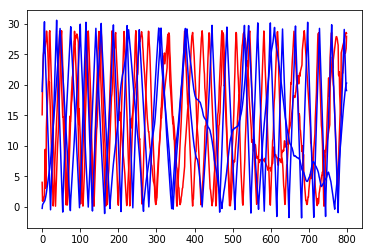




Object Dims:


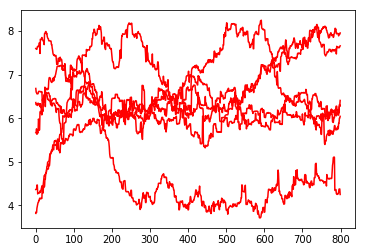

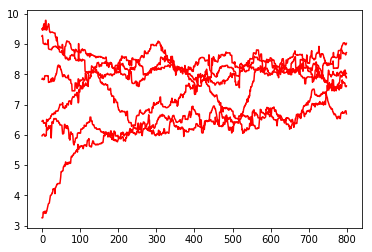

In [26]:
lfm = fmean.shape[0]

for i in range(n_agents):
    plt.plot(range(fmean.shape[0]), fmean[:,i,:2], c='r')
    plt.plot(range(fmean.shape[0]), true[:lfm,i], c='b')
plt.show()

for i in range(n_agents):
    plt.plot(range(fmean.shape[0]), fmean[:,i,:2], c='r')
    plt.plot(range(fmean.shape[0]), true[:lfm,i], c='b')
    plt.show()

print('\n\n\nObject Dims:')
plt.plot(range(fmean.shape[0]), fmean[:,:,2], c='r')
plt.show()

plt.plot(range(fmean.shape[0]), fmean[:,:,3], c='r')
plt.show()

In [27]:
# for k in fed[:1]:
#     moment, weights = k[0]
#     hist, xa , ya = np.histogram2d(moment[:,0], moment[:,1], bins=50, weights=weights)
    
#     fig, ax1 = plt.subplots(1,1)
#     ax1.imshow(hist, cmap='jet', interpolation='nearest')
#     ax1.set_xticklabels(xa)
#     ax1.set_yticklabels(ya)
    
#     moment, weights = k[1]
#     hist, xa , ya = np.histogram2d(moment[:,0], moment[:,1], bins=50, weights=weights)
    
#     fig, ax1 = plt.subplots(1,1)
#     ax1.imshow(hist, cmap='jet', interpolation='nearest')
#     ax1.set_xticklabels(xa)
#     ax1.set_yticklabels(ya)
#     plt.show()

In [28]:
images = []
key = np.random.randint(0, 255, 3)

for i, obs in enumerate(true):
    im = np.zeros([im_x, im_y, 3])
    pred = filtrated[i]
    
    for particle in range(filtrated.shape[1]):
        for filt in range(fmean.shape[1]):
            f = pred[particle, filt][:2].astype('int')
            im[tuple(f)] = (key*13*(filt+1))%255#filt + 2
    for h, obj in enumerate(obs):
        x, y = tuple(obj.astype('int'))
        x = min(im_x-1, x)
        y = min(im_y-1, y)
        im[x,y] = (255,0,0)
    images.append(im)
    

In [29]:
import cv2
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('output2.avi',fourcc, 8.0, (im_y*10, im_x*10), True)

for im in images:
    frame = im
    if True:
        frame = cv2.resize(im, (im_y*10, im_x*10), interpolation = cv2.INTER_CUBIC)
        frame = frame.astype('float') - frame.min()
        frame = 255*frame/frame.max()
        frame = frame.astype('uint8')
        #frame = cv2.flip(frame,1)

        # write the flipped frame
        out.write(frame)#[:,:,0])

        #cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished

out.release()
#cv2.destroyAllWindows()

In [29]:
frame.min()

0

In [64]:
frame.shape

(300, 310, 3)

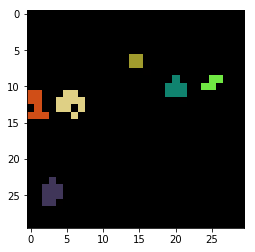

In [35]:
plt.imshow(frame)
plt.show()

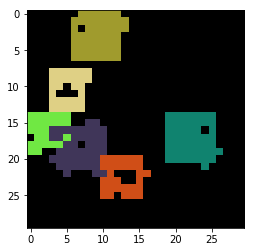

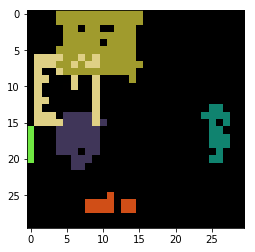

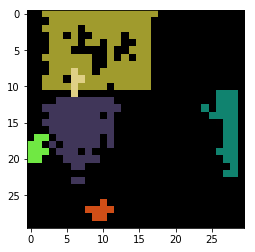

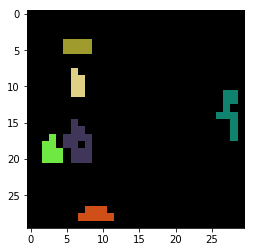

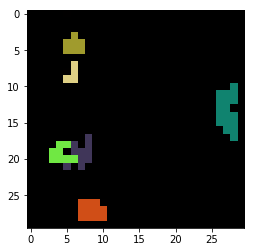

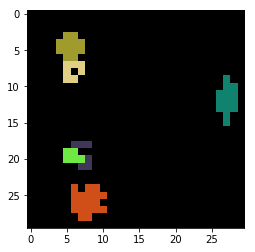

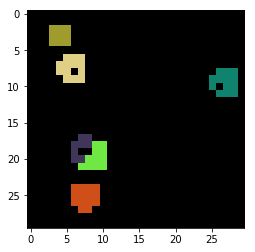

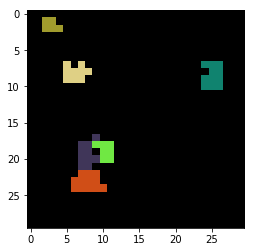

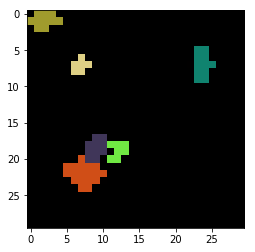

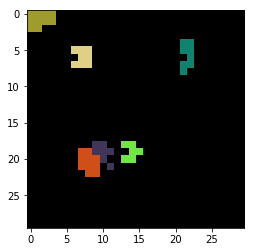

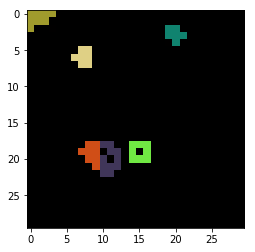

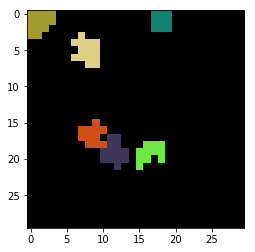

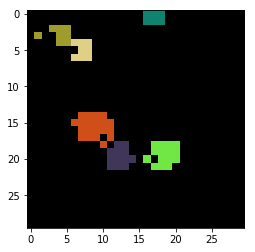

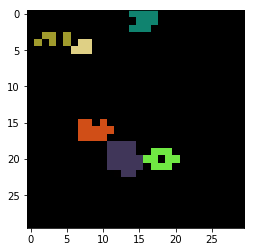

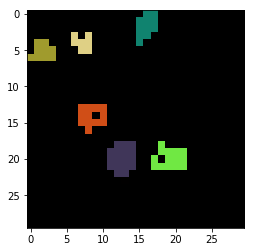

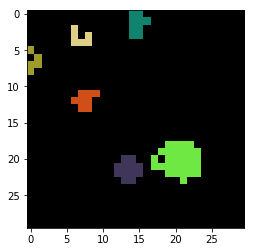

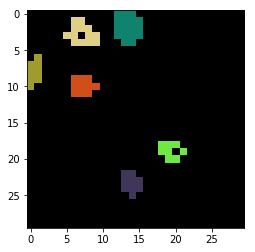

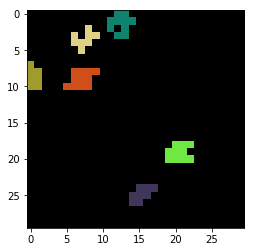

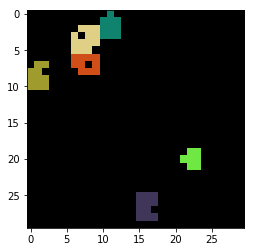

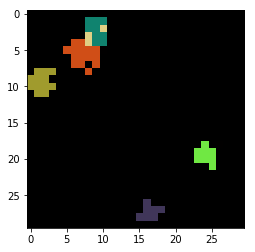

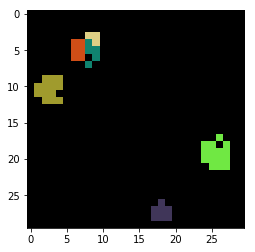

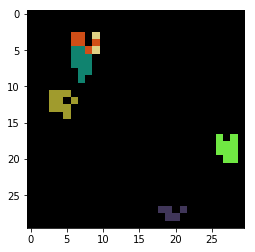

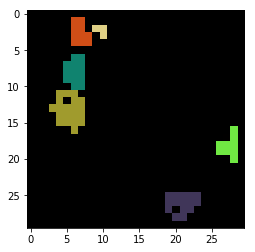

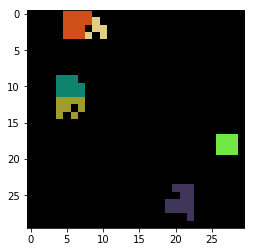

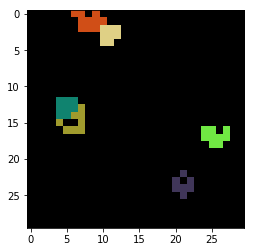

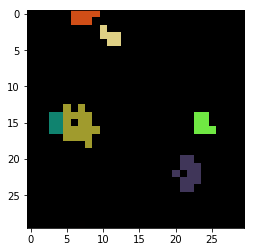

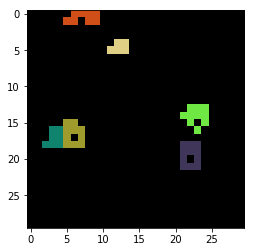

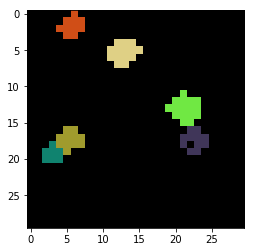

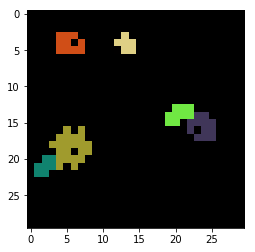

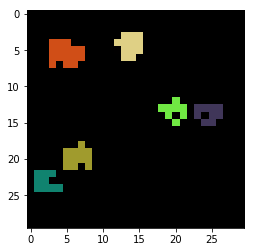

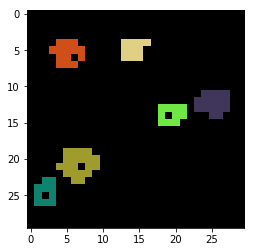

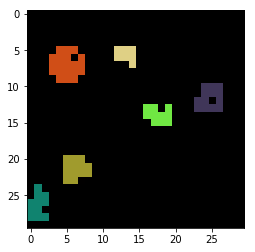

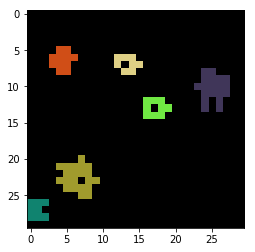

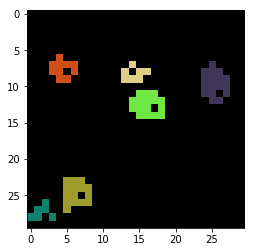

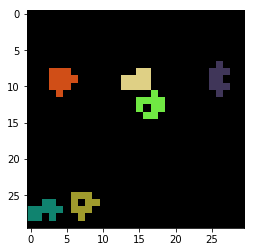

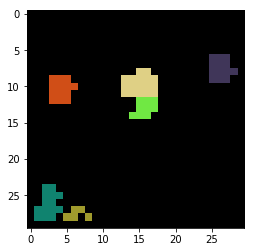

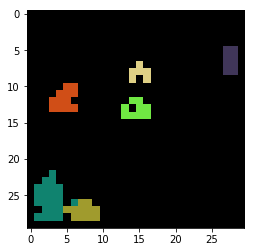

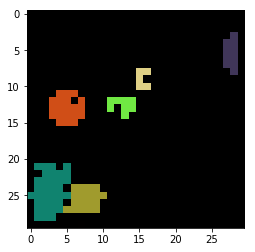

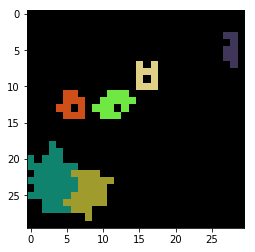

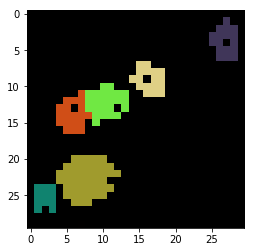

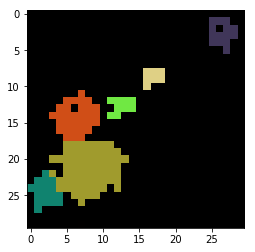

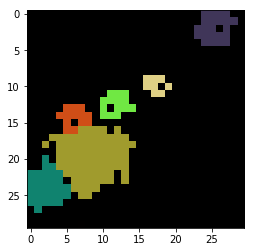

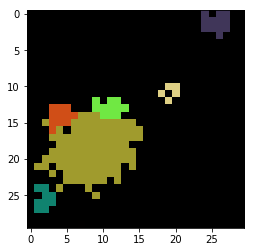

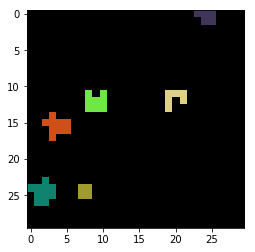

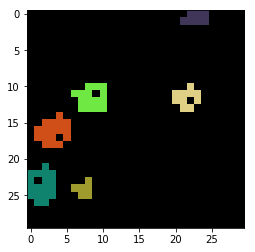

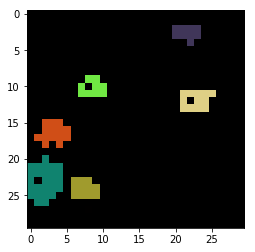

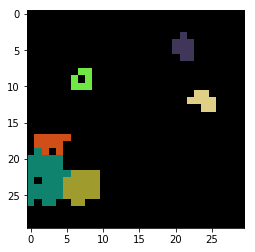

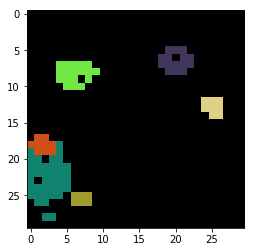

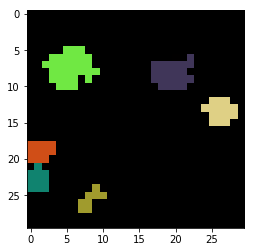

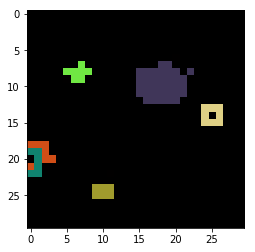

In [36]:
for im in images[:50]:
    plt.imshow(im)
    plt.show()